<a href="https://colab.research.google.com/github/Loinen/geodata_analysis/blob/main/lab2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
# for colab
# ! pip install statsmodels --upgrade

In [117]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.ar_model import AutoReg
from math import sqrt
from statsmodels.tsa.ar_model import ar_select_order

    TEMP - Mean temperature (.1 Fahrenheit)
    SLP - Mean sea level pressure for the day in millibars to tenths. Missing = 9999.9 (.1 mb)
    WDSP – Mean wind speed (.1 knots)

In [118]:
random.seed(42)
original_data = pd.read_csv("https://raw.githubusercontent.com/Loinen/geodata_analysis/main/data/data_spb.csv", index_col=1, na_values='NA', usecols=['STATION', 'DATE', 'TEMP', 'SLP', 'WDSP'])
original_data

STATION     SLP  TEMP   WDSP
DATE                                        
1990-02-03  26060099999  1010.5  34.3  999.9
1990-02-13  26060099999  1002.7  31.8    5.8
1990-04-29  26060099999  1014.9  50.4    7.8
1990-01-01  26063099999  1020.3  27.5    7.0
1990-01-02  26063099999  1020.4  22.2    3.6
...                 ...     ...   ...    ...
2019-12-31  26072099999   993.5  35.8    5.1
2020-01-01  26063099999  9999.9  33.1    9.1
2020-01-02  26063099999  9999.9  38.7   11.0
2020-01-01  26072099999  1006.7  30.2    3.6
2020-01-02  26072099999  1002.5  37.6    6.6

[13949 rows x 4 columns]

In [119]:
original_data = original_data.loc[original_data.STATION == 26063099999]
original_data = original_data.drop(columns='STATION')

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


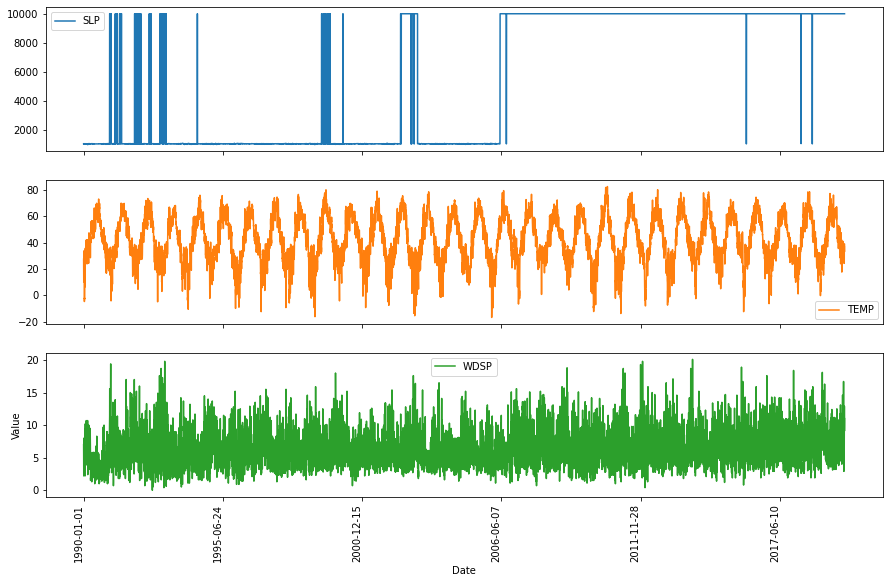

In [120]:
original_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()
# we can see a lot of gaps at the end

In [121]:
# удаление пропущенных значений + убираем все после 2006 года
original_data = original_data.loc[:'2006-01-01']

data = original_data.copy()
missing_vals = data.loc[data.SLP==9999.9]
data = data.replace(9999.9, np.nan, regex=True)
data = data.dropna(subset=['SLP'])

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


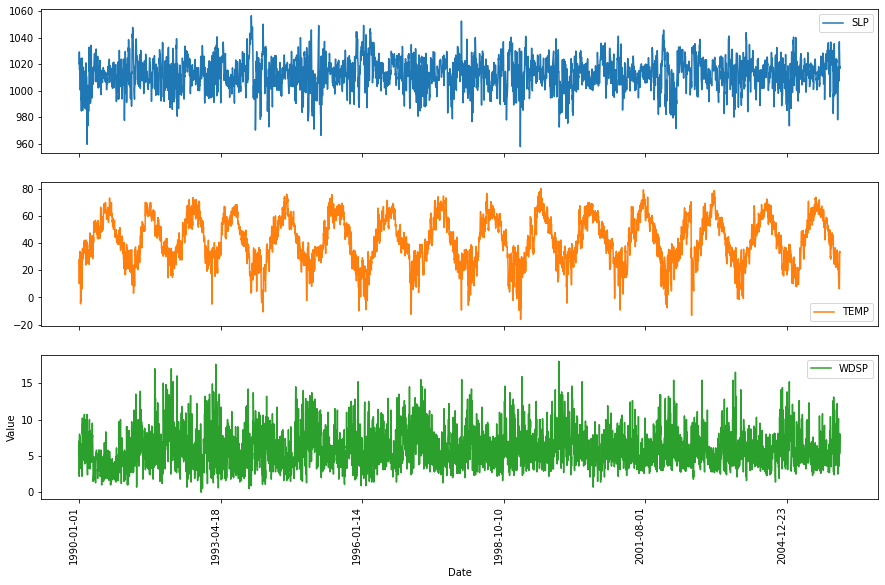

In [122]:
data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

In [123]:
data.shape

(5375, 3)

In [124]:
missing_vals.shape

(469, 3)

# Авторегрессия

In [125]:
pressure = data['SLP'].values

In [126]:
def autoreg(series, prediction_size, train_size, lags, trend, exog=None):
    X_train_autoreg, X_test_autoreg = series[len(series)-train_size-prediction_size:len(series)-prediction_size],\
    series[len(series)-prediction_size:]
    
    if exog is None:
        autoreg_model = AutoReg(X_train_autoreg, lags=lags, trend=trend)
        autoreg_model_fit = autoreg_model.fit()
        
        predictions = autoreg_model_fit.predict(start=len(X_train_autoreg)-1, 
                                end=len(X_test_autoreg)+len(X_train_autoreg)-2, dynamic=True)
    else:
        exog_train, exog_test = exog[len(exog)-train_size-prediction_size:len(exog)-prediction_size],\
        exog[len(exog)-prediction_size:]
        
        autoreg_model = AutoReg(X_train_autoreg, lags=lags, trend=trend, exog=exog_train)
        autoreg_model_fit = autoreg_model.fit()
        
        predictions = autoreg_model_fit.predict(start=len(X_train_autoreg)-1, 
                                end=len(X_test_autoreg)+len(X_train_autoreg)-2, dynamic=True, exog_oos=exog_test)
    
    rmse = sqrt(mean_squared_error(X_test_autoreg, predictions))
    mae = mean_absolute_error(X_test_autoreg, predictions)
    
    fig, ax = plt.subplots()

    ax.plot(X_test_autoreg, label="Test")
    ax.plot(predictions, label="Prediction")

    ax.legend()
    plt.show()
    
    print("rmse", rmse)
    print("mae", mae)
    
    return predictions

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


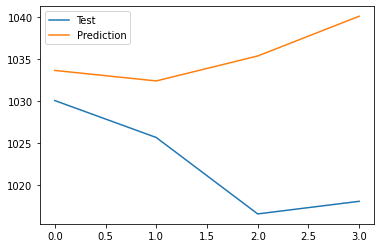

rmse 14.980634147001654
mae 12.792355783375342


In [127]:
prediction_size = 4
predictions_5_points = autoreg(pressure, prediction_size, 10, 3, 'n')

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


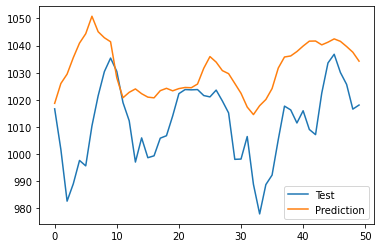

rmse 23.315749689242068
mae 19.457385276143857


In [128]:
prediction_size = 50
predictions_5_points = autoreg(pressure, prediction_size, 100, 26, 'ct')

In [129]:
temp = data['TEMP'].values

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


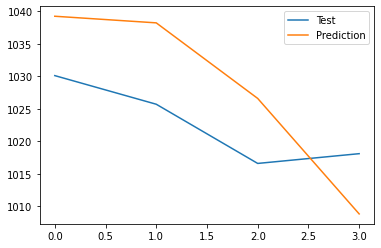

rmse 10.311685111410355
mae 10.221492848818087


In [130]:
prediction_size = 4
predictions_5_points = autoreg(pressure, prediction_size, 10, 3, 'n', exog=temp) # pressure?

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


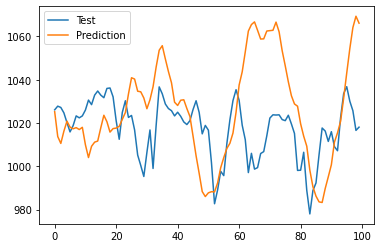

rmse 25.68878041191814
mae 20.083215844031677


In [131]:
prediction_size = 100
predictions_5_points = autoreg(pressure, prediction_size, 100, 24, 'ct', exog=temp)

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


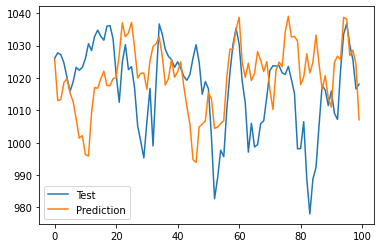

rmse 16.59716330703654
mae 13.123891858255618


In [132]:
prediction_size = 100
predictions_5_points = autoreg(pressure, prediction_size, 150, 40, 'ct', exog=temp)

# Вариант с 1 семестра (линейная регрессия)

Mean absolute error =  8.313310354591888
Mean squared error =  113.10300175061428


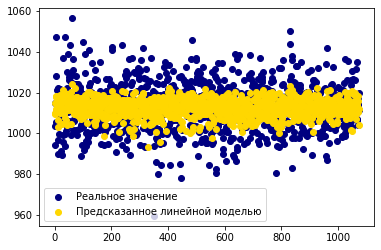

In [133]:
X = data[['WDSP', 'TEMP']]
y = data[['SLP']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

model = LinearRegression(normalize=True).fit(X_train,y_train)
predicted_del = model.predict(X_test)
predicted_del

mae = mean_absolute_error(y_test, predicted_del)
mse = mean_squared_error(y_test, predicted_del)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

x = range(len(y_test))
plt.scatter(x, y_test, color='navy', label=u'Реальное значение')
plt.scatter(x, predicted_del, color='gold', label=u'Предсказанное линейной моделью')
plt.legend()
plt.show()

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


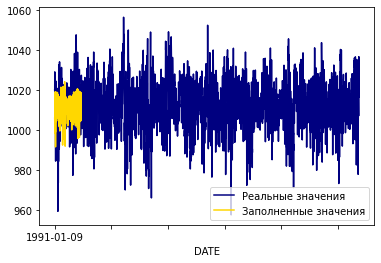

In [134]:
# заполнение пропусков лин регрессией
X_miss = missing_vals[['WDSP', 'TEMP']]
y_pred = model.predict(X_miss)

missing_vals['SLP'] = y_pred

data['SLP'].plot(color='navy', label='Реальные значения')
missing_vals['SLP'].plot(color='gold', label='Заполненные значения')
plt.legend()

In [135]:
train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


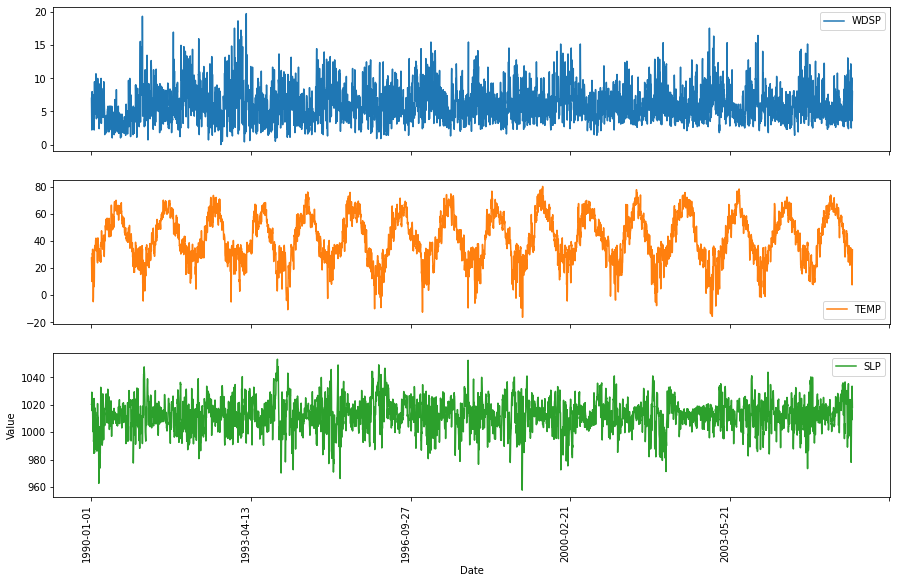

In [136]:
filled_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

In [137]:
model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_lr = model.predict(X_test)

In [138]:
mae = mean_absolute_error(y_test, predicted_lr)
mse = mean_squared_error(y_test, predicted_lr)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse) 

Mean absolute error =  8.31331035459188
Mean squared error =  113.1030017506141


# Медиана

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


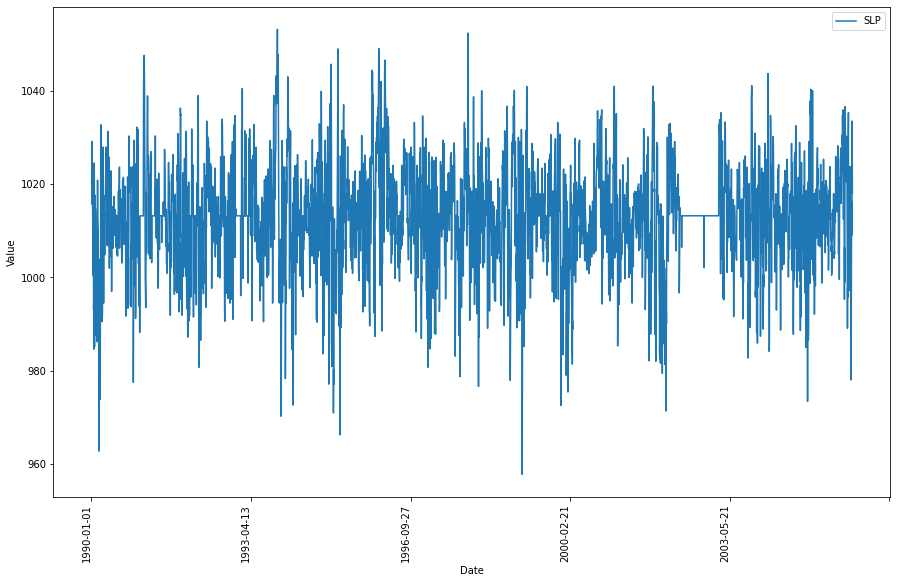

Mean absolute error =  8.293829557237592
Mean squared error =  112.76744765270718


In [139]:
missing_vals['SLP'] = train['SLP'].median()

train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

filled_data['SLP'].plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_lr = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_lr)
mse = mean_squared_error(y_test, predicted_lr)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


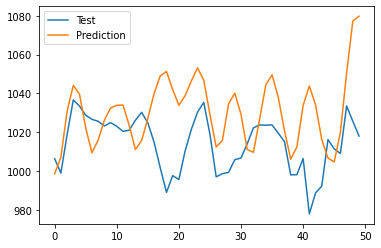

rmse 26.10038213604444
mae 20.30663322476139


In [140]:
pressure = filled_data['SLP'].values
prediction_size = 50
predictions_5_points = autoreg(pressure, prediction_size, 100, 40, 'ct')

# Линейная интерполяция (проверка на рандомных пропусках)

100 (500, 3)
C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


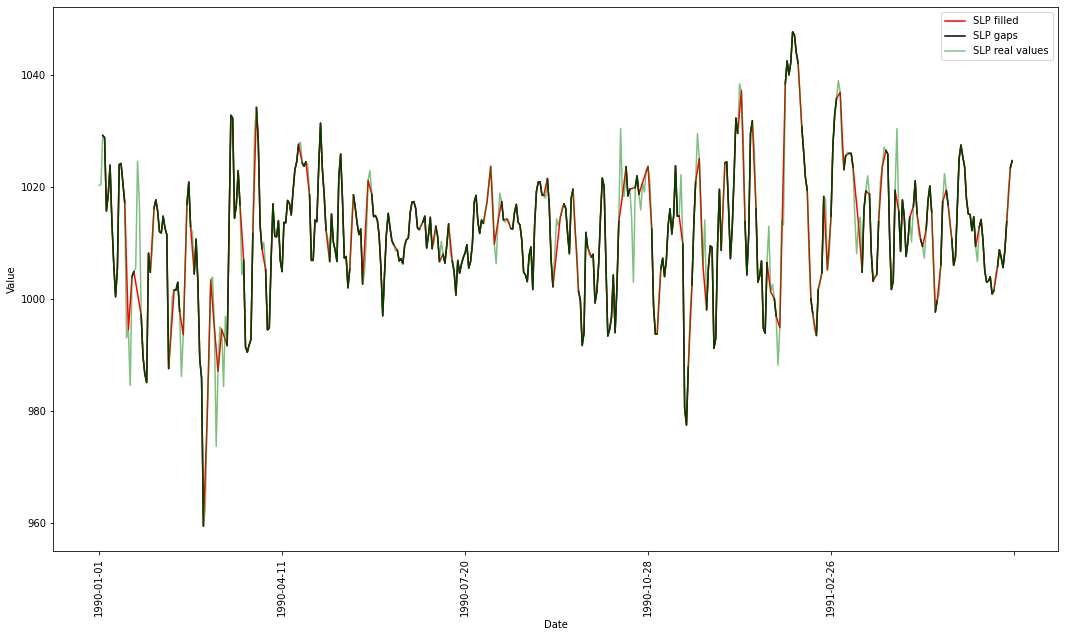

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


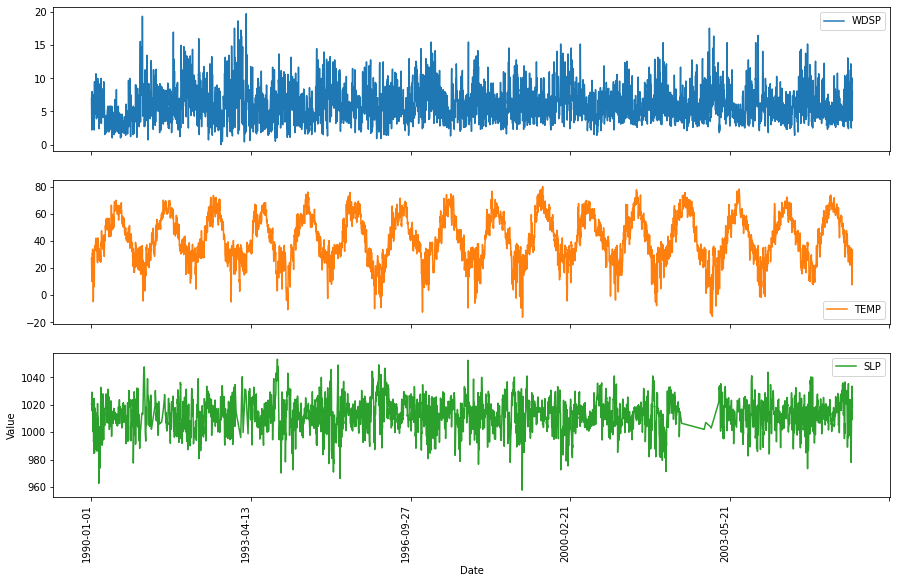

Mean absolute error =  8.300717034195577
Mean squared error =  113.03582283661285


In [141]:
missing_nan = original_data.copy()
missing_nan = missing_nan.replace(9999.9, np.nan, regex=True)

random_missing = data.copy()
random_missing = random_missing[:500]
n_missing = int(random_missing.SLP.size/5) 
print(n_missing, random_missing.shape)
random_idx = np.random.choice(random_missing.index, n_missing, replace=False)
random_missing.at[random_idx, "SLP"] = np.nan
random_missing = random_missing.sort_index()

filled = random_missing.copy()
filled['SLP'] = filled[['SLP']].interpolate(method='linear')['SLP']

filled.SLP.plot(figsize=(18, 10),color='red', label = 'SLP filled')
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP gaps')
data[:500].SLP.plot(figsize=(18, 10),color='green',alpha = 0.5, label = 'SLP real values')
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

missing_interpolate = missing_nan[['SLP']].interpolate(method='linear')['SLP']
missing_vals['SLP'] = missing_interpolate

train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

filled_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_lr = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_lr)
mse = mean_squared_error(y_test, predicted_lr)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


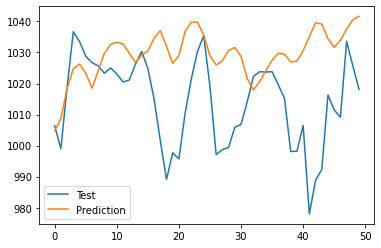

rmse 21.945723490538022
mae 16.89276424135516


In [142]:
pressure = filled_data['SLP'].values
prediction_size = 50
predictions_5_points = autoreg(pressure, prediction_size, 100, 26, 'ct')

# Интерполяция сплайнами

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


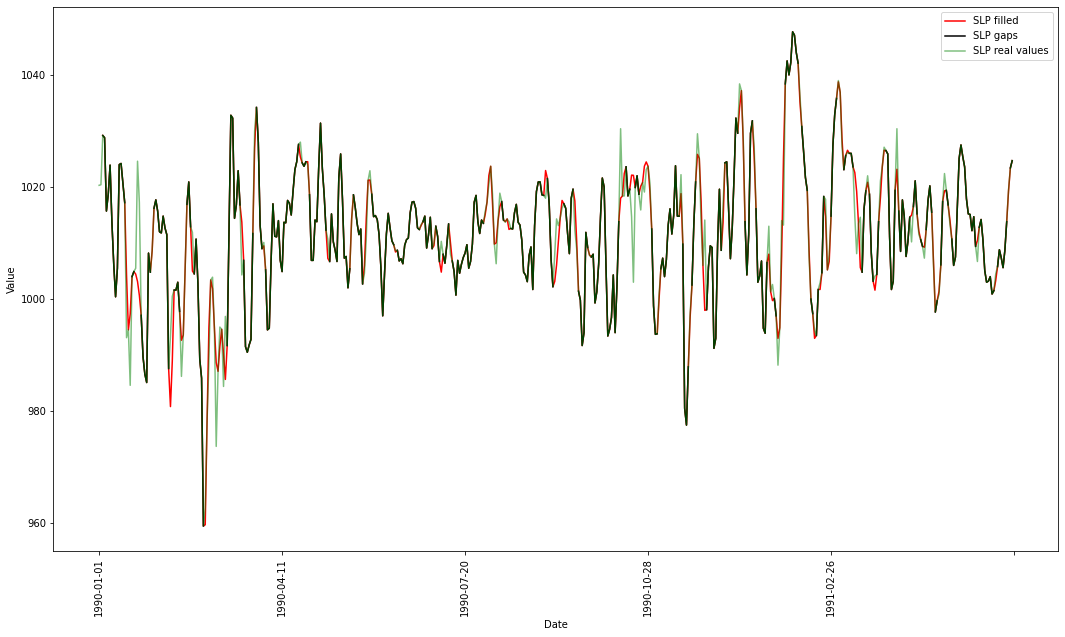

In [143]:
s = pd.Series(random_missing["SLP"].values)
filled['SLP'] = s.interpolate(method='spline', order=3).values

filled.SLP.plot(figsize=(18, 10),color='red', label = 'SLP filled')
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP gaps')
data[:500].SLP.plot(figsize=(18, 10),color='green',alpha = 0.5, label = 'SLP real values')
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

In [144]:
missing_spline = missing_nan.copy()
s = pd.Series(missing_spline["SLP"].values)

missing_spline['SLP'] = s.interpolate(method='spline', order=3).values
missing_vals['SLP'] = missing_spline

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


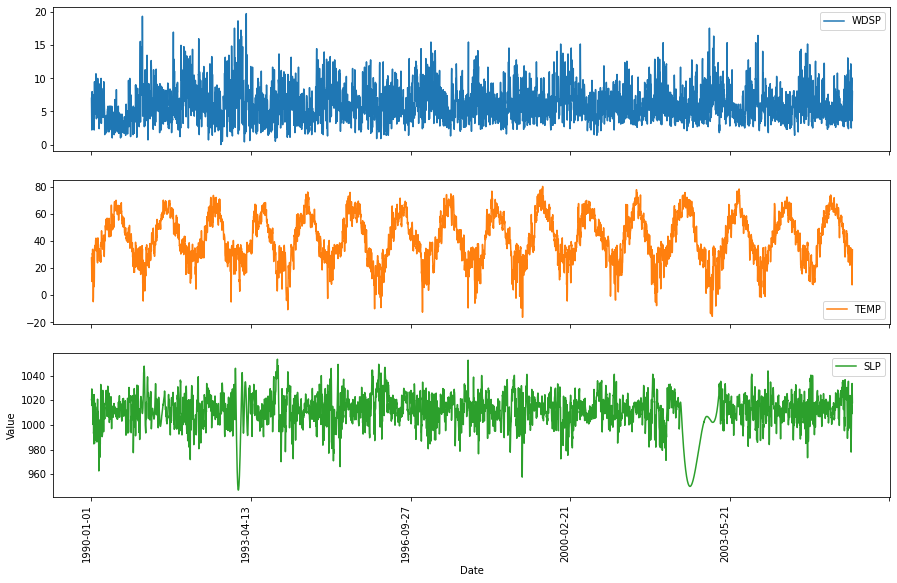

Mean absolute error =  8.490055469025435
Mean squared error =  116.48842739609749


In [145]:
train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

filled_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_lr = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_lr)
mse = mean_squared_error(y_test, predicted_lr)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


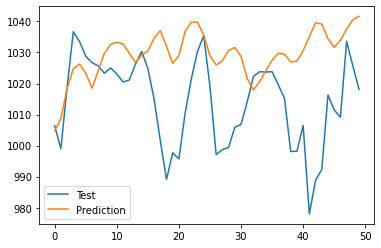

rmse 21.945723490538022
mae 16.89276424135516


In [146]:
pressure = filled_data['SLP'].values
prediction_size = 50
predictions_5_points = autoreg(pressure, prediction_size, 100, 26, 'ct')

<h2>KNN</h2>

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


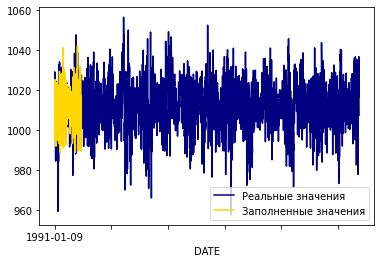

In [147]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)

missing_knn = missing_nan.copy()
missing_knn['SLP'] = imputer.fit_transform(missing_knn)
missing_vals['SLP'] = missing_knn

data['SLP'].plot(color='navy', label='Реальные значения')
missing_vals['SLP'].plot(color='gold', label='Заполненные значения')
plt.legend()
plt.show()

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


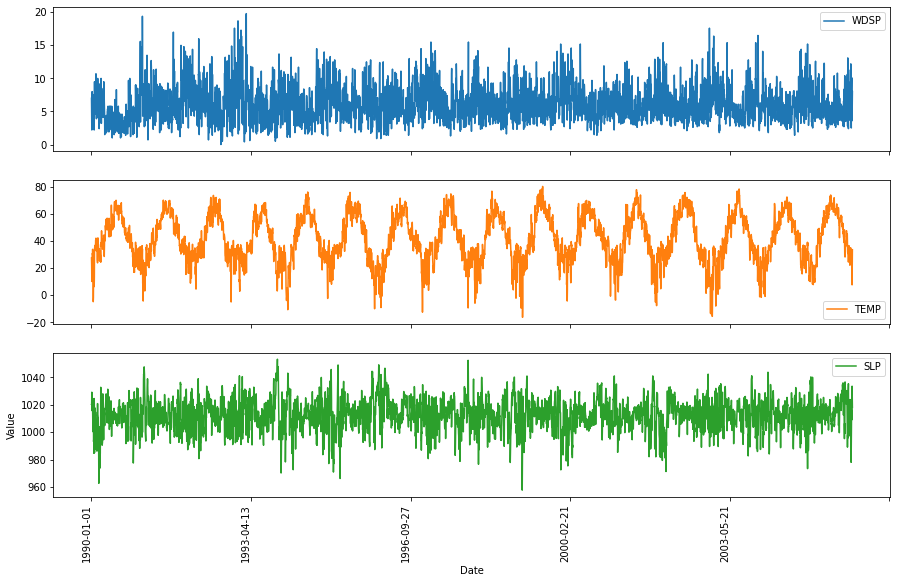

Mean absolute error =  8.307570115479232
Mean squared error =  113.06073974696162


In [148]:
train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

filled_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_knn = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_knn)
mse = mean_squared_error(y_test, predicted_knn)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


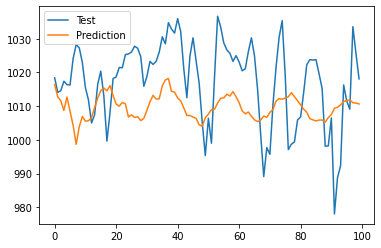

rmse 14.18336506717991
mae 12.35991460888431


In [149]:
# Тут я поменял цифры, чтобы посмотреть, что получится. (Спойлер. Если везде поменять цифры, то везде опять одинаковые результаты)
pressure = filled_data['SLP'].values
prediction_size = 100
predictions_5_points = autoreg(pressure, prediction_size, 150, 40, 'ct')

<h2>Итеративно</h2>

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


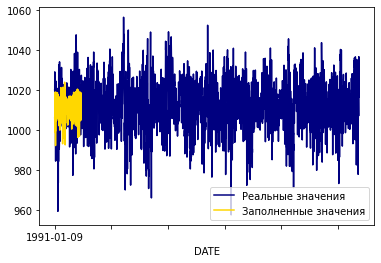

In [150]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

missing_inter = missing_nan.copy()
imp_mean = IterativeImputer(random_state=0)
imp_mean.fit(data.dropna())

missing_inter['SLP'] = imp_mean.transform(missing_inter)
missing_vals['SLP'] = missing_inter

data['SLP'].plot(color='navy', label='Реальные значения')
missing_vals['SLP'].plot(color='gold', label='Заполненные значения')
plt.legend()
plt.show()

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


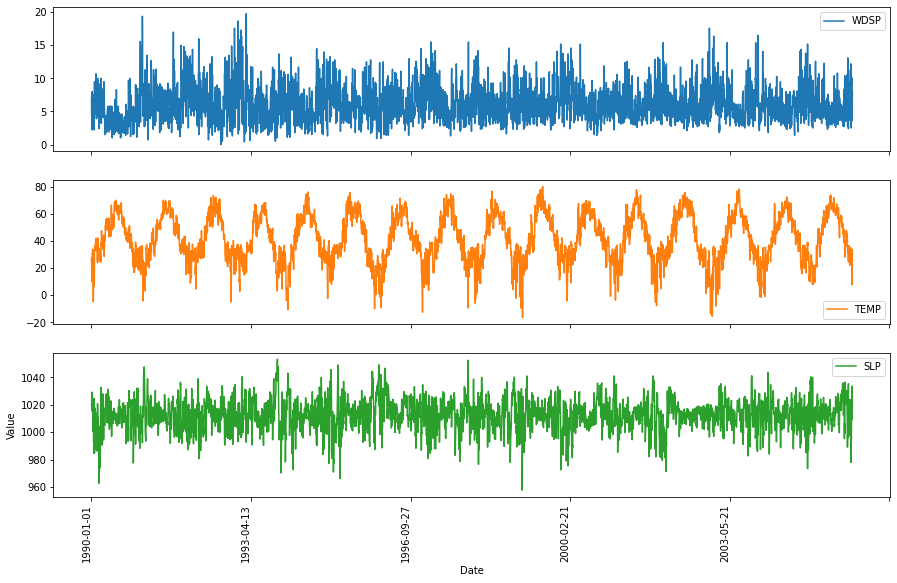

Mean absolute error =  8.312103797466422
Mean squared error =  113.07632241266136


In [151]:
train = pd.concat([X_train, y_train], axis=1)
filled_data = pd.concat([train, missing_vals])
filled_data = filled_data.sort_index()
new_X_train = filled_data[['WDSP', 'TEMP']]
new_y_train = filled_data[['SLP']]

filled_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

model = LinearRegression(normalize=True).fit(new_X_train, new_y_train)
predicted_lr = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_lr)
mse = mean_squared_error(y_test, predicted_lr)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

C:\Users\romav\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


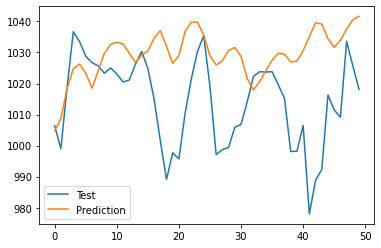

rmse 21.945723490538022
mae 16.89276424135516


In [152]:
pressure = filled_data['SLP'].values
prediction_size = 50
predictions_5_points = autoreg(pressure, prediction_size, 100, 26, 'ct')